<a href="https://colab.research.google.com/github/ykitaguchi77/Article_implementation/blob/main/3D-UNET_brain_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Brain_segmentation_pytorch 3D-UNET**

CTの複数画像を立体的にsegmentationする

GitHub: hhttps://github.com/mateuszbuda/brain-segmentation-pytorch

WebPage: https://towardsdatascience.com/creating-and-training-a-u-net-model-with-pytorch-for-2d-3d-semantic-segmentation-model-building-6ab09d6a0862


In [1]:
!git clone https://github.com/mateuszbuda/brain-segmentation-pytorch.git

#作業フォルダを移動
%cd brain-segmentation-pytorch

Cloning into 'brain-segmentation-pytorch'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 97 (delta 6), reused 2 (delta 1), pack-reused 85
Unpacking objects: 100% (97/97), done.
/content/brain-segmentation-pytorch


#Kaggle_3M datasetのダウンロード

まずKaggleに登録してAPIの使用許可を申請する必要あり。詳細は下記を参考に。

https://www.currypurin.com/entry/2018/kaggle-api

In [2]:
# mount Gdrive
from google.colab import drive
drive.mount('/content/drive')

# kaggle ライブラリのインストール
!pip install kaggle

# 一時フォルダに .kaggleフォルダを作成
!mkdir ~/.kaggle

# MyDrive の kaggle.json　(permissionファイル) を一時フォルダ内の .kaggleフォルダにコピー
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

# アクセス権限の設定
!chmod 600 ~/.kaggle/kaggle.json

!mkdir ~/.kaggle

# zipファイルのダウンロード
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation
#!kaggle competitions download -c rsna-2022-cervical-spine-fracture-detection -p /content/drive/MyDrive/Kaggle
# 解凍
!unzip ./lgg-mri-segmentation.zip -d ./

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: ./lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_

# ここから

In [3]:
#Requirementsからモジュールをインストール
#※バージョンがconflictしまくるのでバージョン指定なし
#medpy以外はすでに入っている

modules = """
numpy
tensorflow
scikit-learn
scikit-image
imageio
medpy
Pillow
scipy
pandas
tqdm
"""

with open("requirements.txt", mode="w") as f:
    f.write(modules)
!pip install -r requirements.txt

import argparse
import os

import numpy as np
import torch
from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg
from medpy.filter.binary import largest_connected_component
from skimage.io import imsave
from torch.utils.data import DataLoader
from tqdm import tqdm

from dataset import BrainSegmentationDataset as Dataset
from unet import UNet
from utils import dsc, gray2rgb, outline

import numpy as np
from PIL import Image
import glob


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 26.3 MB/s 
     |████████████████████████████████| 52.8 MB 1.1 MB/s 
  Created wheel for medpy: filename=MedPy-0.4.0-cp37-cp37m-linux_x86_64.whl size=754498 sha256=faa091ec45949b1f201c9bd6e2778c3ecab5c2db057eb9cfd5e0483495880b4e
  Stored in directory: /root/.cache/pip/wheels/b0/57/3a/da1183f22a6afb42e11138daa6a759de233fd977a984333602
Successfully built medpy


#**Modules**

In [4]:
def postprocess_per_volume(
    input_list, pred_list, true_list, patient_slice_index, patients
):
    volumes = {}
    num_slices = np.bincount([p[0] for p in patient_slice_index]) #各要素が何個ずつあるかを数える
    index = 0
    for p in range(len(num_slices)):
        volume_in = np.array(input_list[index : index + num_slices[p]])
        volume_pred = np.round(
            np.array(pred_list[index : index + num_slices[p]])
        ).astype(int)
        volume_pred = largest_connected_component(volume_pred)
        volume_true = np.array(true_list[index : index + num_slices[p]])
        volumes[patients[p]] = (volume_in, volume_pred, volume_true)
        index += num_slices[p]
    return volumes

def dsc_distribution(volumes):
    dsc_dict = {}
    for p in volumes:
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        dsc_dict[p] = dsc(y_pred, y_true, lcc=False)
    return dsc_dict

def plot_dsc(dsc_dist):
    y_positions = np.arange(len(dsc_dist))
    dsc_dist = sorted(dsc_dist.items(), key=lambda x: x[1])
    values = [x[1] for x in dsc_dist]
    labels = [x[0] for x in dsc_dist]
    labels = ["_".join(l.split("_")[1:-1]) for l in labels]
    fig = plt.figure(figsize=(12, 8))
    canvas = FigureCanvasAgg(fig)
    plt.barh(y_positions, values, align="center", color="skyblue")
    plt.yticks(y_positions, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.1))
    plt.xlim([0.0, 1.0])
    plt.gca().axvline(np.mean(values), color="tomato", linewidth=2)
    plt.gca().axvline(np.median(values), color="forestgreen", linewidth=2)
    plt.xlabel("Dice coefficient", fontsize="x-large")
    plt.gca().xaxis.grid(color="silver", alpha=0.5, linestyle="--", linewidth=1)
    plt.tight_layout()
    canvas.draw()
    plt.close()
    s, (width, height) = canvas.print_to_buffer()
    return np.fromstring(s, np.uint8).reshape((height, width, 4))

def outline(image, mask, color):
    mask = np.round(mask)
    yy, xx = np.nonzero(mask)
    for y, x in zip(yy, xx):
        if 0.0 < np.mean(mask[max(0, y - 1) : y + 2, max(0, x - 1) : x + 2]) < 1.0:
            image[max(0, y) : y + 1, max(0, x) : x + 1] = color
    return image


import os
import random

import numpy as np
import torch
from skimage.io import imread
from skimage.exposure import rescale_intensity
from skimage.transform import resize
from torch.utils.data import Dataset

from utils import crop_sample, pad_sample, resize_sample, normalize_volume


# #dataset (datasetフォルダに入っているのでここに書く必要ないが、解説のために再定義)
class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        validation_cases=10,
        seed=42,
    ):
        assert subset in ["all", "train", "validation"] #all, train,validation以外のsubsetにするとエラーを出す

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for (dirpath, dirnames, filenames) in os.walk(images_dir): #dirpath: 親フォルダのパス、filenames: ファイルの名前
            image_slices = []
            mask_slices = []

            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),  
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ): #tifがついているファイルを番号順にソートする
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename: #maskがファイル名についているもの
                    mask_slices.append(imread(filepath, as_gray=True))
                else: #ついていないもの
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1] #TCGA_HT_8018_19970411
                volumes[patient_id] = np.array(image_slices[1:-1]) #volumes: マスクなし画像,RGB(最初と最後の1枚ずつを除外する（informationなどがある？？？？）)
                masks[patient_id] = np.array(mask_slices[1:-1]) #masks: マスク画像, grayscale

        print(len(volumes))
        print(len(masks))

        self.patients = sorted(volumes) #patientsのリストをソート

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=validation_cases) #validation_casesで指定した分だけ無作為に抜き出す
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients] #スライスの数だけvolumesとmaskのペアを作る


        ##############################################################
        # print(f"volumes: {volumes[self.patients[2]].shape}") #(18,256,256,3) --> 枚数、縦、横、RGB
        # print(f"masks: {masks[self.patients[2]].shape}") #(18,256,256)
        ##############################################################
        ##################################################################
        print(f"normalize_volume: {self.volumes[2][0].shape}") #2症例目の0(volume)の形状 (18,256,256,3) --> 枚数、縦、横、RGB
        print(f"normalize_masks: {self.volumes[2][1].shape}") #2症例目の1(masks)の形状 (18,256,256)
        #################################################################

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume ...何をしているのかいまいちよくわからない...
        self.volumes = [crop_sample(v) for v in self.volumes]


        print("padding {} volumes...".format(subset))
        # pad to square  横長の画像を正方形に
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize #256*256にリサイズ
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]  #v: volume, m: mask、上下の10%を除去してノーマライズ

        ##################################################################
        print(f"normalized_volume_shape: {self.volumes[0][0].shape}") #0症例目の0(volume)の形状(18,256,256,3)
        print(f"normalized_masks_shape: {self.volumes[0][1].shape}") #0症例目の1(masks)の形状(18,256,256)
        #################################################################


        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes] #(10)
        print(len(self.slice_weights))
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights #(10)
        ]
        print(f"n_slice_weights: {len(self.slice_weights)}")


        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes] 
        ##################################################################
        print(f"final_volume_shape: {self.volumes[0][0].shape}") #0症例目の0(volume)の形状 (18,256,256,3) --> 枚数、縦、横、RGB
        print(f"final_masks_shape: {self.volumes[0][1].shape}") #2症例目の1(masks)の形状 (18,256,256,1) <--最後に1の次元を追加
        #################################################################
        #################################
        print(len(self.volumes)) #10
        #################################

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        # [(0,0), (0,1),(0,2)...(0,18), (1,0), (1,1), (1,3), ...(1,18)...] 
        num_slices = [v.shape[0] for v, m in self.volumes] #スライス数
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []), 
                sum([list(range(x)) for x in num_slices], []), 
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]
        #print(f"idx:{idx}, patient:{patient}, slice_n:{slice_n}")

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )
 
        v, m = self.volumes[patient]
        image = v[slice_n] #(256,256,3)
        mask = m[slice_n] #(256,256,1)

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor


#以下utilisより抜粋（utilisよりimportされているのでここで定義しなくてもOK）
def crop_sample(x):
    volume, mask = x
    volume[volume < np.max(volume) * 0.1] = 0 #最高densityの0.1倍未満のものはゼロに切り捨てる
    z_projection = np.max(np.max(np.max(volume, axis=-1), axis=-1), axis=-1)
    z_nonzero = np.nonzero(z_projection)
    z_min = np.min(z_nonzero)
    z_max = np.max(z_nonzero) + 1
    y_projection = np.max(np.max(np.max(volume, axis=0), axis=-1), axis=-1)
    y_nonzero = np.nonzero(y_projection)
    y_min = np.min(y_nonzero)
    y_max = np.max(y_nonzero) + 1
    x_projection = np.max(np.max(np.max(volume, axis=0), axis=0), axis=-1)
    x_nonzero = np.nonzero(x_projection)
    x_min = np.min(x_nonzero)
    x_max = np.max(x_nonzero) + 1
    return (
        volume[z_min:z_max, y_min:y_max, x_min:x_max],
        mask[z_min:z_max, y_min:y_max, x_min:x_max],
    )

def pad_sample(x): #横長の画像を正方形にする
    volume, mask = x
    a = volume.shape[1]
    b = volume.shape[2]
    if a == b:
        return volume, mask
    diff = (max(a, b) - min(a, b)) / 2.0
    if a > b:
        padding = ((0, 0), (0, 0), (int(np.floor(diff)), int(np.ceil(diff))))
    else:
        padding = ((0, 0), (int(np.floor(diff)), int(np.ceil(diff))), (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)
    return volume, mask

def normalize_volume(volume):
    p10 = np.percentile(volume, 10)
    p99 = np.percentile(volume, 99)
    volume = rescale_intensity(volume, in_range=(p10, p99)) #skimageを用いてintensityの上下を切ってnormalizeする
    m = np.mean(volume, axis=(0, 1, 2))
    s = np.std(volume, axis=(0, 1, 2))
    volume = (volume - m) / s
    return volume

def resize_sample(x, size=256): #skimage.transform.resizeを用いてsize=256にリサイズ）
    volume, mask = x
    v_shape = volume.shape
    out_shape = (v_shape[0], size, size)
    mask = resize(
        mask,
        output_shape=out_shape,
        order=0,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    ) #order=0: nearest neighbor
    out_shape = out_shape + (v_shape[3],)
    volume = resize(
        volume,
        output_shape=out_shape,
        order=2,
        mode="constant",
        cval=0,
        anti_aliasing=False,
    ) #order=2: bi-quadratic
    return volume, mask


#**Interference**

In [5]:
#これをインポートすれば上のmoduleは不要
#from dataset import BrainSegmentationDataset as Dataset


#############################
#weights_dir = "./weights/unet.pt" #weightの保存先
weights_dir = "/content/drive/MyDrive/Kaggle/Brain_segmentation_3dUNET/unet.pt" #下でtrainingしたモデルを用いる場合
#############################

#predictionsフォルダ作成
os.makedirs("./predictions", exist_ok=True)

#deviceを定義
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

#データセットとデータローダー
dataset = BrainSegmentationDataset(
    images_dir="/content/brain-segmentation-pytorch/kaggle_3m", #kaggle dataset使用
    subset="validation",
    image_size=256,
    random_sampling=False,
)
loader = DataLoader(
    dataset, batch_size=32, drop_last=False, num_workers=0
)

with torch.set_grad_enabled(False):
    unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
    
    #モデルのweightをロード
    state_dict = torch.load(weights_dir, map_location=device)
    unet.load_state_dict(state_dict)

    unet.eval()
    unet.to(device)

    input_list = []
    pred_list = []
    true_list = []

    for i, data in tqdm(enumerate(loader)):
        x, y_true = data
        x, y_true = x.to(device), y_true.to(device)

        y_pred = unet(x)
        y_pred_np = y_pred.detach().cpu().numpy()
        pred_list.extend([y_pred_np[s] for s in range(y_pred_np.shape[0])])

        y_true_np = y_true.detach().cpu().numpy()
        true_list.extend([y_true_np[s] for s in range(y_true_np.shape[0])])

        x_np = x.detach().cpu().numpy()
        input_list.extend([x_np[s] for s in range(x_np.shape[0])])

    volumes = postprocess_per_volume(
        input_list,
        pred_list,
        true_list,
        loader.dataset.patient_slice_index,
        loader.dataset.patients,
    )

    dsc_dist = dsc_distribution(volumes)

    dsc_dist_plot = plot_dsc(dsc_dist)
    imsave("./dsc.png", dsc_dist_plot)

    for p in volumes:
        x = volumes[p][0]
        y_pred = volumes[p][1]
        y_true = volumes[p][2]
        for s in range(x.shape[0]):
            image = gray2rgb(x[s, 1])  # channel 1 is for FLAIR
            image = outline(image, y_pred[s, 0], color=[255, 0, 0]) #赤: prediction
            image = outline(image, y_true[s, 0], color=[0, 255, 0]) #緑：groundtruth
            filename = "{}-{}.png".format(p, str(s).zfill(2))
            filepath = os.path.join("./predictions", filename)
            imsave(filepath, image)

reading validation images...
110
110
preprocessing validation volumes...
normalize_volume: (18, 256, 256, 3)
normalize_masks: (18, 256, 256)
cropping validation volumes...
padding validation volumes...
resizing validation volumes...
normalizing validation volumes...
normalized_volume_shape: (28, 256, 256, 3)
normalized_masks_shape: (28, 256, 256)
10
n_slice_weights: 10
final_volume_shape: (28, 256, 256, 3)
final_masks_shape: (28, 256, 256, 1)
10
done creating validation dataset


11it [00:08,  1.36it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: ./predictions/TCGA_DU_7014_19860618-57.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: ./predictions/TCGA_DU_6408_19860521-51.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: ./predictions/TCGA_DU_6408_19860521-52.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: ./predictions/TCGA_DU_6408_19860521-53.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: ./predictions/TCGA_DU_6404_19850629-50.png is a low contrast image
/usr/local/lib/python3.7/dist-packages/ipykernel_lau

### prediction結果を表示 ###

3列で全てを表示

In [ ]:
#prediction結果を表示 (赤：pred、緑：groundtruth)
images = [Image.open(img) for img in glob.glob("./predictions/*")[0:90]]

cols =3
rows = len(images)//cols+1 #縦の行


fig = plt.figure(figsize=(cols*5, rows*5))


for i, im in enumerate(images):
    fig.add_subplot(rows, cols, i+1).set_title(str(i+1))
    plt.imshow(im)

plt.show()

#**Train**

※loggerの部分はtensorflow1→tensorflow2に書き直さないといけないので、省略しています

In [ ]:
import json
import os

import numpy as np
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

#from dataset import BrainSegmentationDataset as Dataset #上で定義し直しているのでインポートしない
#from logger import Logger
from loss import DiceLoss
from transform import transforms
from unet import UNet
from utils import log_images, dsc

from statistics import mean
import time



def dsc_per_volume(validation_pred, validation_true, patient_slice_index):
    dsc_list = []
    num_slices = np.bincount([p[0] for p in patient_slice_index]) #要素の数を数える、すなわち患者毎の枚数をリスト化する
    index = 0
    for p in range(len(num_slices)):
        y_pred = np.array(validation_pred[index : index + num_slices[p]])
        y_true = np.array(validation_true[index : index + num_slices[p]])
        dsc_list.append(dsc(y_pred, y_true))
        index += num_slices[p]
    return dsc_list


def log_loss_summary(logger, loss, step, prefix=""):
    logger.scalar_summary(prefix + "loss", np.mean(loss), step)



#main

#時間測定開始
time_start = time.perf_counter()

#random_seed
np.random.seed = 42

#parameters
batch_size = 8
image_size = 256
num_workers = 0
lr = 0.0001
n_epochs = 100
vis_freq = 10 #frequency of saving images to log file
vis_images = 200 #number of visualization images to save in log file
#weight_path = "./weights"
weights_dir = "/content/drive/MyDrive/Kaggle/Brain_segmentation_3dUNET"
load_weight = False #Gdriveに保存しているweightをロードするかどうか
earlystopping = 10 #０にするとearlystoppingをoffにする

#フォルダ作成
os.makedirs("./weights", exist_ok=True)
os.makedirs("./logs", exist_ok=True)

# snapshotargs()

#deviceを定義
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")


if 'loader_valid' in globals(): #データローダー作成済みなら省略する（読み込みに時間かかるので）
    pass
else:
    #dataset
    dataset_train = BrainSegmentationDataset(
        images_dir="/content/brain-segmentation-pytorch/kaggle_3m",
        subset="train",
        image_size=image_size,
        transform=transforms(scale=0.05, angle=15, flip_prob=0.5), #scale, angle: augmentationの拡大縮小および回転角度
    )
    dataset_valid = BrainSegmentationDataset(
        images_dir="/content/brain-segmentation-pytorch/kaggle_3m",
        subset="validation",
        image_size=image_size,
        random_sampling=False,
    )

    #dataloader
    loader_train = DataLoader(
        dataset_train,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=num_workers,
        worker_init_fn= None,
    )
    loader_valid = DataLoader(
        dataset_valid,
        batch_size=batch_size,
        drop_last=False,
        num_workers=num_workers,
        worker_init_fn= None,
    )
    loaders = {"train": loader_train, "valid": loader_valid}

    print(f"elapsed_time: {time.perf_counter() - time_start}")
    print("")

#model
unet = UNet(in_channels=BrainSegmentationDataset.in_channels, out_channels=BrainSegmentationDataset.out_channels)
unet.to(device)

if load_weight is True:
    unet.load_state_dict(torch.load (os.path.join(weights_dir, "unet.pt")))
    print("loading weight...")
else:
    pass

dsc_loss = DiceLoss()
best_validation_dsc = 0.0

optimizer = optim.Adam(unet.parameters(), lr=lr)

#logger = Logger("./logs")
loss_train = []
loss_valid = []

step = 0
earlystopping_counter = 0
time_start = time.perf_counter() #時間測定開始
for epoch in tqdm(range(n_epochs), total=n_epochs): 
    for phase in ["train", "valid"]:
        if phase == "train":
            unet.train()
        else:
            unet.eval()

        validation_pred = []
        validation_true = []

        for i, data in enumerate(loaders[phase]):
            if phase == "train":
                step += 1

            x, y_true = data #x: 入力画像、y_true: ラベル画像
            x, y_true = x.to(device), y_true.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == "train"):
                y_pred = unet(x)

                loss = dsc_loss(y_pred, y_true)

                if phase == "valid":
                    loss_valid.append(loss.item())
                    val_loss = loss.item() #途中経過表示用
                    y_pred_np = y_pred.detach().cpu().numpy()
                    validation_pred.extend(
                        [y_pred_np[s] for s in range(y_pred_np.shape[0])]
                    )
                    y_true_np = y_true.detach().cpu().numpy()
                    validation_true.extend(
                        [y_true_np[s] for s in range(y_true_np.shape[0])]
                    )
                    if (epoch % vis_freq == 0) or (epoch == n_epochs - 1):
                        if i * batch_size < vis_images:
                            tag = "image/{}".format(i)
                            num_images = vis_images - i * batch_size
                            # logger.image_list_summary(
                            #     tag,
                            #     log_images(x, y_true, y_pred)[:num_images],
                            #     step,
                            # )

                if phase == "train":
                    loss_train.append(loss.item())
                    train_loss = loss.item() #途中経過表示用
                    loss.backward()
                    optimizer.step()

            if phase == "train" and (step + 1) % 10 == 0:
                #log_loss_summary(logger, loss_train, step)
                loss_train = []

        if phase == "valid":
            #log_loss_summary(logger, loss_valid, step, prefix="val_")
            mean_dsc = np.mean(
                dsc_per_volume(
                    validation_pred,
                    validation_true,
                    loader_valid.dataset.patient_slice_index,
                )
            )
            # logger.scalar_summary("val_dsc", mean_dsc, step)
            
            ####途中経過####
            print("")
            print(f"epoch: {str(epoch+1)}")
            print(f"train_loss: {train_loss:.5f}")
            print(f"val_loss: {val_loss:.5f}")
            print(f"val_dsc: {mean_dsc:.5f}") 
            print(f"elapsed_time: {time.perf_counter() - time_start:.5f}")
            
            if mean_dsc > best_validation_dsc:
                print(f'mean_dsc increased ({best_validation_dsc:5f} --> {mean_dsc:5f}). Saving model...')
                best_validation_dsc = mean_dsc
                torch.save(unet.state_dict(), os.path.join(weights_dir, "unet.pt"))
                earlystopping_counter = 0 #reset earlystopping
            else:
                earlystopping_counter += 1
                if earlystopping >= 1:
                    print(f"earlystopping_counter: {earlystopping_counter}")
                    if earlystopping_counter == earlystopping:
                          print("The training stopped with earlystopping!")
                          break
            print("")
            loss_valid = []

print("Best validation mean DSC: {:4f}".format(best_validation_dsc))



#**Quick look of Segmentations images**

https://www.kaggle.com/code/khairoo/quick-look-of-segmentations-images

In [9]:
! pip install --quiet pylibjpeg pylibjpeg-libjpeg pydicom
! pip install --quiet wandb
import pandas as pd
import numpy as np 
import scipy as sc 
import pydicom as dicom
import torch
import torchvision as tv
from tqdm.notebook import tqdm
import wandb

from pydicom import dcmread
import pylibjpeg
import cv2
import matplotlib.pyplot as plt 
from random import randint


# Packages
import nibabel as nb
import os
import sys
from pathlib import Path
import warnings
warnings.simplefilter("ignore")

     |████████████████████████████████| 1.8 MB 35.2 MB/s 
     |████████████████████████████████| 158 kB 85.7 MB/s 
     |████████████████████████████████| 181 kB 83.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 157 kB 99.1 MB/s 
     |████████████████████████████████| 157 kB 102.1 MB/s 
     |████████████████████████████████| 157 kB 82.8 MB/s 
     |████████████████████████████████| 157 kB 82.9 MB/s 
     |████████████████████████████████| 157 kB 100.3 MB/s 
     |████████████████████████████████| 157 kB 92.6 MB/s 
     |████████████████████████████████| 157 kB 98.8 MB/s 
     |████████████████████████████████| 156 kB 64.5 MB/s 


In [10]:
root_dir = '/content/drive/MyDrive/Kaggle/rsna-2022-cervical-spine-fracture-detection'
train = pd.read_csv(root_dir+"/train.csv")

In [11]:
train.head(10)

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0
5,1.2.826.0.1.3680043.4859,1,0,0,0,0,0,1,0
6,1.2.826.0.1.3680043.18659,1,0,0,0,1,0,0,1
7,1.2.826.0.1.3680043.17364,0,0,0,0,0,0,0,0
8,1.2.826.0.1.3680043.849,0,0,0,0,0,0,0,0
9,1.2.826.0.1.3680043.24045,1,0,0,0,0,0,0,1


In [12]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019 entries, 0 to 2018
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   StudyInstanceUID  2019 non-null   object
 1   patient_overall   2019 non-null   int64 
 2   C1                2019 non-null   int64 
 3   C2                2019 non-null   int64 
 4   C3                2019 non-null   int64 
 5   C4                2019 non-null   int64 
 6   C5                2019 non-null   int64 
 7   C6                2019 non-null   int64 
 8   C7                2019 non-null   int64 
dtypes: int64(8), object(1)
memory usage: 142.1+ KB


In [13]:
train['predicted'] = train['C1'].map(str) + ',' +  train['C2'].map(str) + ','+ train['C3'].map(str) + ','+ train['C4'].map(str) + \
','+ train['C5'].map(str) + ','+ train['C6'].map(str) + ','+ train['C7'].map(str) 

train.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7,predicted
0,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0,"1,1,0,0,0,0,0"
1,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0,"0,1,0,0,0,0,0"
2,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0,"0,1,0,0,0,0,0"
3,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0,"0,0,0,0,0,0,0"
4,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0,"0,0,0,0,1,0,0"


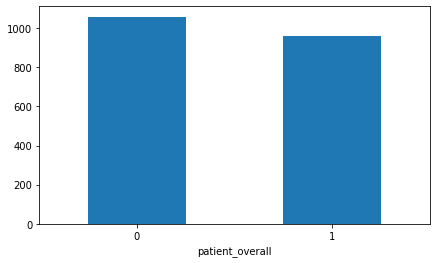

In [14]:
patient_overall_count = train.groupby('patient_overall')['StudyInstanceUID'].nunique()
plt.figure(figsize = (7,4))
patient_overall_count.plot(kind= 'bar', rot=0)

In [15]:
test = pd.read_csv(root_dir + '/test.csv')
test


,row_id,StudyInstanceUID,prediction_type
0,1.2.826.0.1.3680043.10197_C1,1.2.826.0.1.3680043.10197,C1
1,1.2.826.0.1.3680043.10454_C1,1.2.826.0.1.3680043.10454,C1
2,1.2.826.0.1.3680043.10690_C1,1.2.826.0.1.3680043.10690,C1


In [17]:
train_bounding_boxes = pd.read_csv(root_dir + "/train_bounding_boxes.csv")
train_bounding_boxes.head(10)



,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
5,1.2.826.0.1.3680043.10051,213.56364,216.71419,25.13455,47.92717,138
6,1.2.826.0.1.3680043.10051,209.00000,214.57591,36.06131,51.56834,139
7,1.2.826.0.1.3680043.10051,204.25455,212.24727,47.47636,57.71635,140
8,1.2.826.0.1.3680043.10051,205.00000,213.87342,45.00000,59.12658,141
9,1.2.826.0.1.3680043.10051,205.18545,214.76814,42.89892,63.43364,142


In [18]:
sample_submission= pd.read_csv(root_dir + "/sample_submission.csv")
sample_submission


,row_id,fractured
0,1.2.826.0.1.3680043.10197_C1,0.5
1,1.2.826.0.1.3680043.10454_C1,0.5
2,1.2.826.0.1.3680043.10690_C1,0.5


## Review images

1.2.826.0.1.3680043.10001/8.dcm


Text(0.5, 1.0, 'Train regular image')

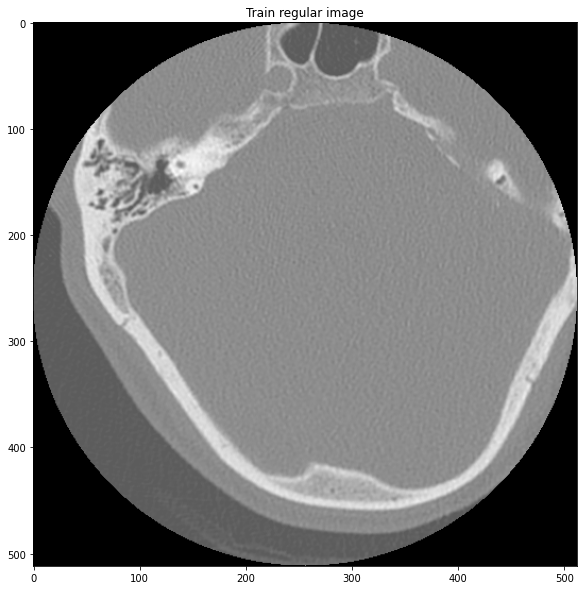

In [19]:
def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img=dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array    
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    data=(data * 255).astype(np.uint8)
    return cv2.cvtColor(data, cv2.COLOR_GRAY2RGB), img

rand= randint(0, 10)
print(f'1.2.826.0.1.3680043.10001/{rand}.dcm')
im, meta = load_dicom(root_dir + f'/train_images/1.2.826.0.1.3680043.10001/{rand}.dcm')
plt.figure(figsize = (10,10
                ))
plt.imshow(im)
plt.title('Train regular image')

In [20]:
path = root_dir + '/segmentations/1.2.826.0.1.3680043.12833.nii'
img = nb.load(path)
print(img)

# Convert to numpy array
seg = img.get_fdata()[:, ::-1, ::-1].transpose(2, 1, 0)
seg.shape

<class 'nibabel.nifti1.Nifti1Image'>
data shape (512, 512, 261)
affine: 
[[-3.49609405e-01 -0.00000000e+00  0.00000000e+00  9.33252029e+01]
 [-0.00000000e+00  3.49609405e-01 -0.00000000e+00  5.96747971e+01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00 -3.65000000e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 261   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : uint16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.         0.3496094  0.3496094  1.         0.         0.
  0.         0.       ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
c

(261, 512, 512)

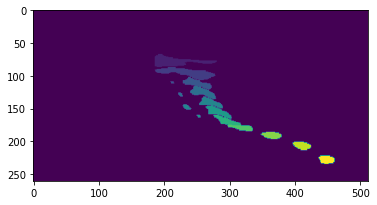

In [21]:
# Plot images
test = seg[:,:,200]
plt.imshow(test)
plt.show()

In [ ]:
# Quick display of a Nifti image

# Disable Toolbar for plots
plt.rcParams['toolbar'] = 'None'

# Environment and file names
home = str(Path.home())
iFile = root_dir + '/segmentations/1.2.826.0.1.3680043.10633.nii'
oFile=(str(os.path.basename(iFile).replace('.nii.gz','.png').replace('.nii','.png')))

# Set rounding
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})



### IMPORT DATA ###
# Load data
image=nb.load(iFile)

# 3D data
if image.header['dim'][0]==3:
    data=image.get_data()
    # 4D data
elif  image.header['dim'][0]==4:
    data=image.get_data()[:,:,:,0]

# Header
header=image.header

# Set NAN to 0
data[np.isnan(data)] = 0



### PREPARE SOME PARAMETERS ###

# Spacing for Aspect Ratio
sX=header['pixdim'][1]
sY=header['pixdim'][2]
sZ=header['pixdim'][3]

# Size per slice
lX = data.shape[0]
lY = data.shape[1]
lZ = data.shape[2]

# Middle slice number
mX = int(lX/2)
mY = int(lY/2)
mZ = int(lZ/2)

# True middle point
tmX = lX/2.0
tmY = lY/2.0
tmZ = lZ/2.0



### ORIENTATION ###
qfX = image.get_qform()[0,0]
sfX = image.get_sform()[0,0]

if qfX < 0 and (sfX == 0 or sfX < 0):
    oL = 'R'
    oR = 'L'
elif qfX > 0 and (sfX == 0 or sfX > 0):
    oL = 'L'
    oR = 'R'
if sfX < 0 and (qfX == 0 or qfX < 0):
    oL = 'R'
    oR = 'L'
elif sfX > 0 and (qfX == 0 or qfX > 0):
    oL = 'L'
    oR = 'R'



### PLOTTING ###

# Plot main window
fig = plt.figure(
    facecolor='black',
    figsize=(5,4),
    dpi=200
)

# Black background
plt.style.use('dark_background')

# Set title
fig.canvas.set_window_title(oFile.replace('.png',''))


# Coronal
ax1=fig.add_subplot(2,2,1)
imgplot = plt.imshow(
    np.rot90(data[:,mY,:]),
    aspect=sZ/sX,
)
imgplot.set_cmap('gray')

ax1.hlines(tmZ, 0, lX, colors='red', linestyles='dotted', linewidth=.5)
ax1.vlines(tmX, 0, lZ, colors='red', linestyles='dotted', linewidth=.5)

plt.axis('off')


# Sagittal
ax2=fig.add_subplot(2,2,2)
imgplot = plt.imshow(
    np.rot90(data[mX,:,:]),
    aspect=sZ/sY,
)
imgplot.set_cmap('gray')

ax2.hlines(tmZ, 0, lY, colors='red', linestyles='dotted', linewidth=.5)
ax2.vlines(tmY, 0, lZ, colors='red', linestyles='dotted', linewidth=.5)

plt.axis('off')


# Axial
ax3=fig.add_subplot(2,2,3)
imgplot = plt.imshow(
    np.rot90(data[:,:,mZ]),
    aspect=sY/sX
)
imgplot.set_cmap('gray')

ax3.hlines(tmY, 0, lX, colors='red', linestyles='dotted', linewidth=.5)
ax3.vlines(tmX, 0, lY, colors='red', linestyles='dotted', linewidth=.5)

plt.axis('off')

plt.text(-10, mY+5, oL, fontsize=9, color='red') # Label on left side


# Textual information
# sform code
sform=np.round(image.get_sform(),decimals=2)
sform_txt=str(sform).replace('[',' ').replace(']',' ').replace(' ','   ').replace('   -','  -')

# qform code
qform=np.round(image.get_qform(),decimals=2)
qform_txt=str(qform).replace('[',' ').replace(']',' ').replace(' ','   ').replace('   -','  -')

# Dimensions
dims=str(data.shape).replace(', ',' x ').replace('(','').replace(')','')
dim=("Dimensions: "+dims)

# Spacing
spacing=("Spacing: "
         +str(np.round(sX, decimals=2))
         +" x "
         +str(np.round(sY, decimals=2))
         +" x "
         +str(np.round(sZ, decimals=2))
         +" mm"
)

# Data type
type=image.header.get_data_dtype()
type_str=("Data type: "+str(type))

# Volumes
volumes=("Volumes: "+str(image.header['dim'][4]))

# Range
min=np.round(np.amin(data), decimals=2)
max=np.round(np.amax(data), decimals=2)
range=("Range: "+str(min)+" - "+str(max))

text=(
    dim+"\n"
    +spacing+"\n"
    +volumes+"\n"
    +type_str+"\n"
    +range+"\n\n"
    +"sform code:\n"
    +sform_txt+"\n"
    +"\nqform code:\n"
    +qform_txt
)

# Plot text subplot
ax4=fig.add_subplot(2,2,4)
plt.text(
    0.15,
    0.95,
    text,
    horizontalalignment='left',
    verticalalignment='top',
    size=6,
    color='white',
)
plt.axis('off')

# Adjust whitespace
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

# Display
plt.show()

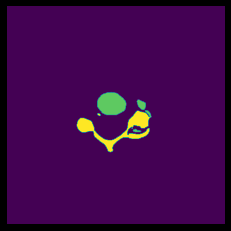

In [24]:
imgplot = plt.imshow(
    np.rot90(data[:,:,mZ]),
    aspect=sY/sX
)
imgplot.set_cmap('viridis')

plt.axis('off')
plt.show()